In [2]:
import os
import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Audio

import librosa
import librosa.display

import np_utils
from keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU
from keras.layers import Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [3]:
audio_data = 'C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [4]:
patient_data=pd.read_csv('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [5]:
diagnosis_df = pd.read_csv('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head(4)

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


In [6]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)


COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: disease, dtype: int64

COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Pneumonia          4.761905
Bronchiolitis      4.761905
LRTI               1.587302
Asthma             0.793651
Name: disease, dtype: float64


<Axes: xlabel='disease', ylabel='count'>

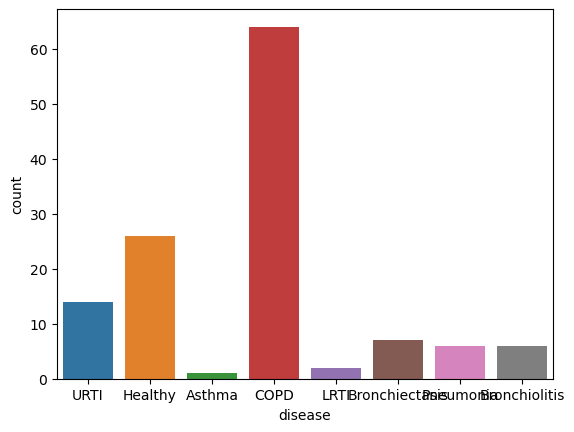

In [7]:
sns.countplot(x='disease', data=diagnosis_df)


In [8]:
path='C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]


In [9]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data


In [10]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y, 0.0008)
    y_shift = shift(y, 3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    plt.figure(figsize=(20, 8))

    plt.subplot(3, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3, 2, 2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3, 2, 3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')

    plt.subplot(3, 2, 4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')

    plt.subplot(3, 2, 5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')

    plt.subplot(3, 2, 6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()


In [11]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)

    plt.figure(figsize=(20, 8))
    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')



    plt.tight_layout()


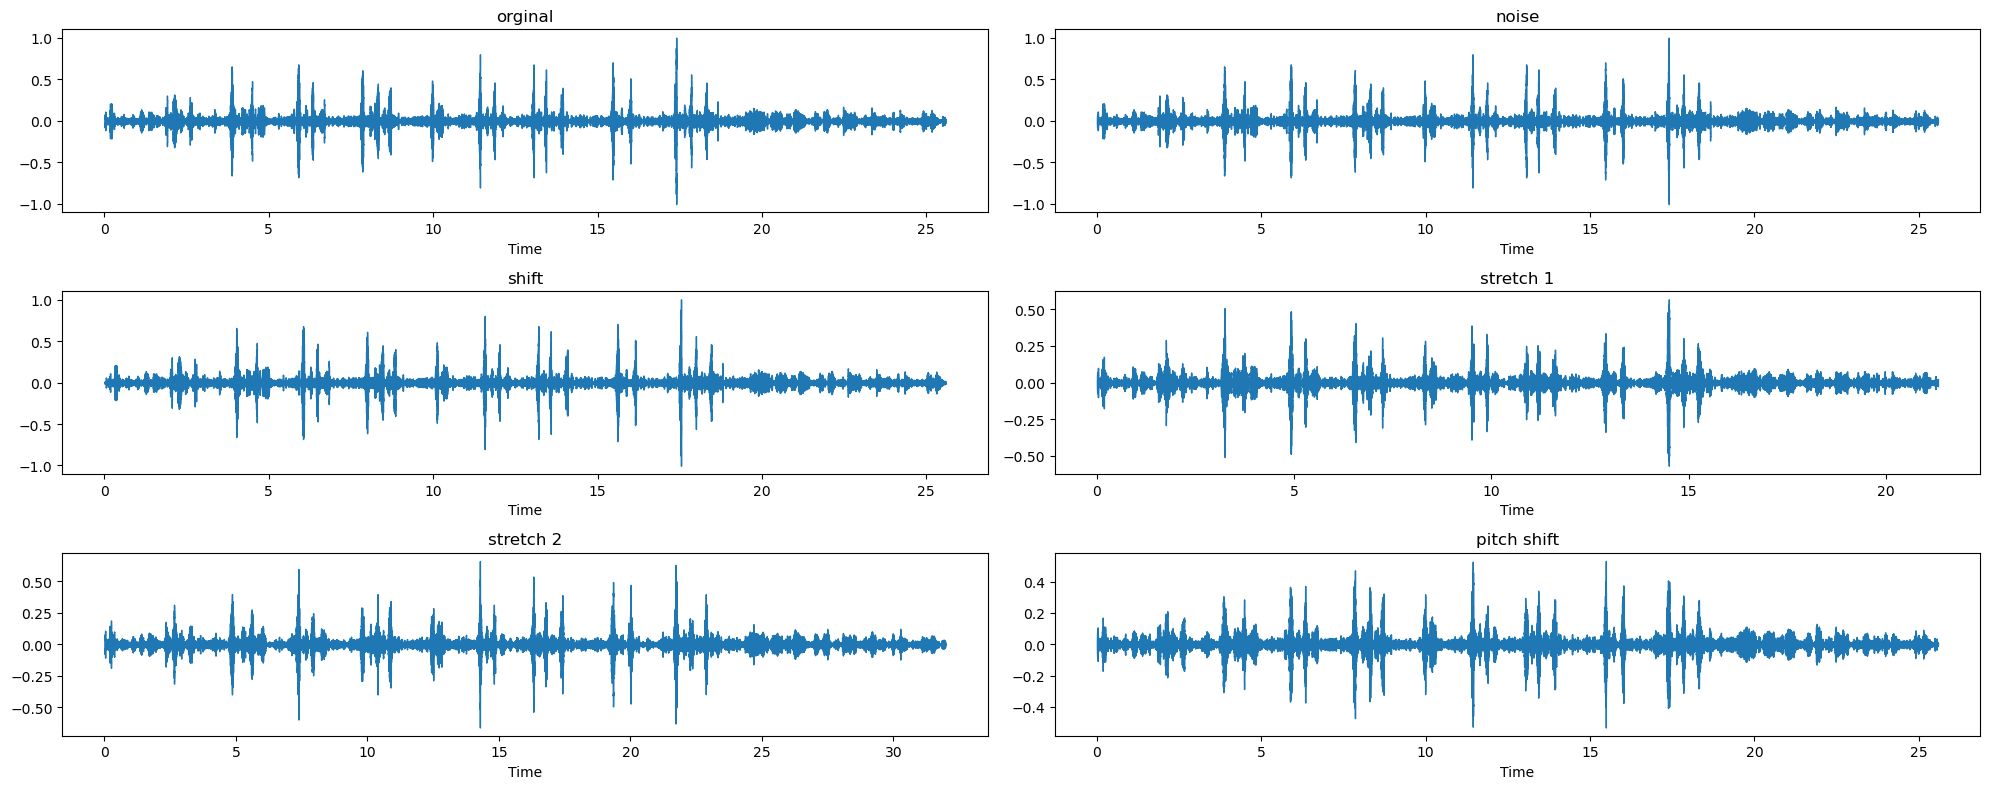

In [12]:
show_audio('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav')

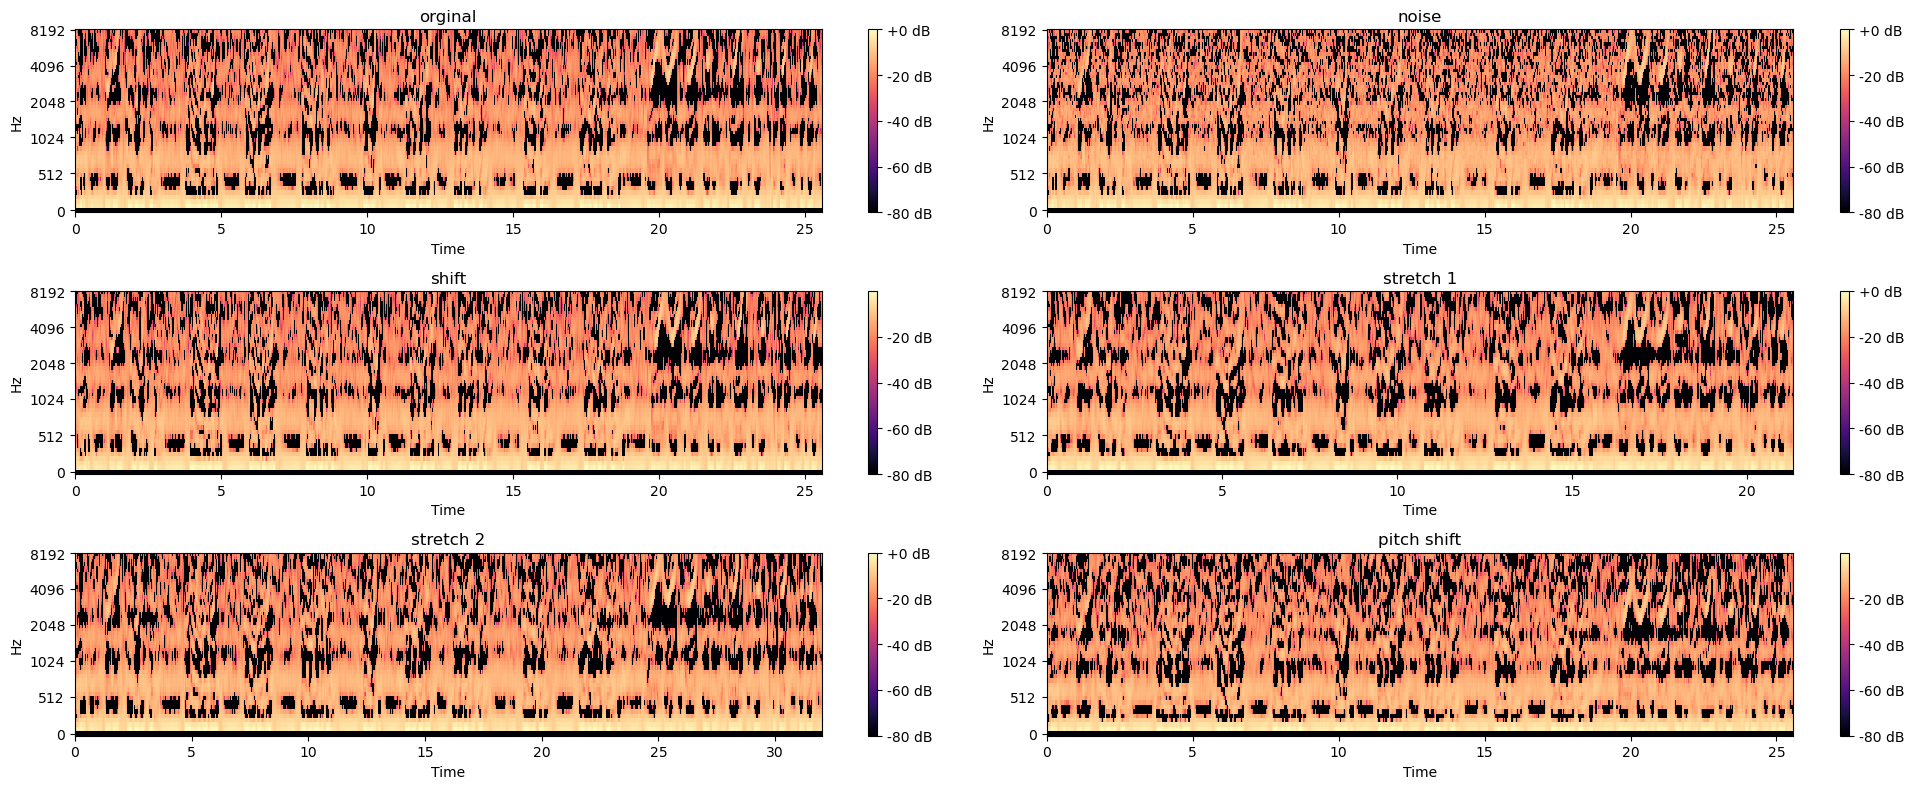

In [13]:
show_audio_features('C:/Users/Admin/Documents/respiratory/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav')

In [14]:
import soundfile as sf

In [15]:
def mfccs_feature_exteraction(dir_):
  X_=[]
  y_=[]
  COPD=[]
  copd_count=0
  data = diagnosis_df
  features = 52
  for soundDir in (os.listdir(dir_)):
    if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':
      p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
      if (p=='COPD'):
        if (soundDir[:6] in COPD) and copd_count<2:
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          COPD.append(soundDir[:6])
          copd_count+=1
          X_.append(mfccs)
          y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
        if (soundDir[:6] not in COPD):
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          COPD.append(soundDir[:6])
          copd_count=0
          X_.append(mfccs)
          y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
      if (p!='COPD'):
        if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs)
          y_.append('Bronchiolitis')
          data_noise = add_noise(data_x,0.001)
          mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_noise)
          y_.append('Bronchiolitis')
          data_shift = shift(data_x,1600)
          mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_shift)
          y_.append('Bronchiolitis')
          data_stretch = stretch(data_x,rate=1.2)
          mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append('Bronchiolitis')
          data_stretch_2 = stretch(data_x,rate=0.8)
          mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch_2)
          y_.append('Bronchiolitis')
          data_pitch_shift = pitch_shift(data_x,3)
          mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append('Bronchiolitis')
        else:
          data_x, sampling_rate = sf.read(dir_ + soundDir)
          mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs)
          y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
          data_noise = add_noise(data_x,0.001)
          mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_noise)
          y_.append(p)
          data_shift = shift(data_x,1600)
          mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_shift)
          y_.append(p)
          data_stretch = stretch(data_x,rate=1.2)
          mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append(p)
          data_stretch_2 = stretch(data_x,rate=0.8)
          mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
          X_.append(mfccs_stretch_2)
          y_.append(p)
          data_pitch_shift = pitch_shift(data_x,3)
          mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
          X_.append(mfccs_stretch)
          y_.append(p)
  X_data = np.array(X_)
  y_data = np.array(y_)
  return X_data, y_data


In [16]:
x_mfccs,y = mfccs_feature_exteraction(audio_data)

In [17]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()
    print (data_count)


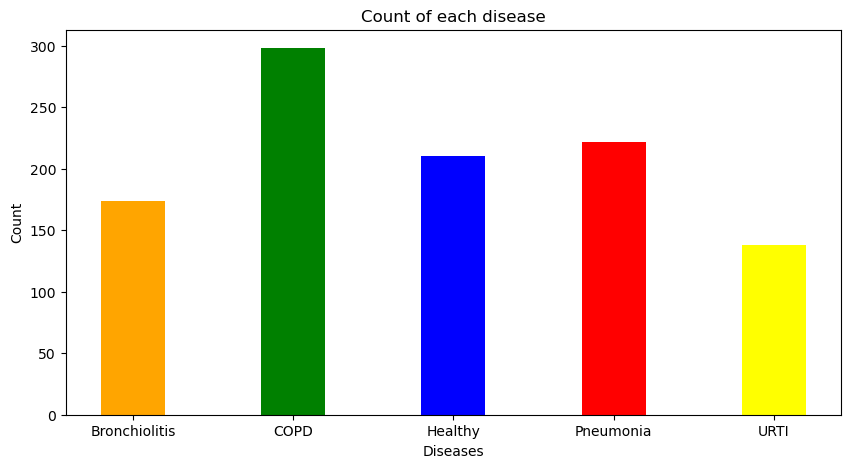

{'Bronchiolitis': 174, 'COPD': 298, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [18]:
augmented_lables_count(y)

In [19]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,1,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,1,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,1]).reshape(1,5) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [20]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((1042, 52), (1042, 5))

In [21]:
mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(794, 52) (183, 52) (65, 52)
(794, 5) (183, 5) (65, 5)


In [22]:
x_train_lstm = np.expand_dims(mfcc_train,axis=2)
x_val_lstm = np.expand_dims(mfcc_val,axis=2)
x_test_lstm = np.expand_dims(mfcc_test,axis=2)

In [23]:
lstm_model = Sequential()

lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(128)))

lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(5, activation='softmax'))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 26, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 1024)          0         
 g1D)                                                            
                                                        

In [24]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/kaggle/working/diagnosis_LSTM_CNN_1.h5",save_best_only=True)]

In [25]:
history = lstm_model.fit(x_train_lstm, lables_train, batch_size=8, epochs=30, validation_data=(x_val_lstm, lables_val),callbacks = cb )

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.5999 - accuracy: 0.2569

C:\Users\Admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 109s 913ms/step - loss: 1.5999 - accuracy: 0.2569 - val_loss: 1.5714 - val_accuracy: 0.2623
Epoch 2/30
100/100 [==============================] - 85s 849ms/step - loss: 1.4795 - accuracy: 0.3174 - val_loss: 1.3801 - val_accuracy: 0.3443
Epoch 3/30
100/100 [==============================] - 88s 881ms/step - loss: 1.4238 - accuracy: 0.3804 - val_loss: 1.3297 - val_accuracy: 0.5027
Epoch 4/30
100/100 [==============================] - 89s 890ms/step - loss: 1.3906 - accuracy: 0.3728 - val_loss: 1.3237 - val_accuracy: 0.4317
Epoch 5/30
100/100 [==============================] - 86s 861ms/step - loss: 1.3457 - accuracy: 0.4068 - val_loss: 1.2505 - val_accuracy: 0.5027
Epoch 6/30
100/100 [==============================] - 84s 836ms/step - loss: 1.2587 - accuracy: 0.4446 - val_loss: 1.4486 - val_accuracy: 0.2678
Epoch 7/30
100/100 [==============================] - 84s 841ms/step - loss: 1.2407 - accuracy: 0.4584 - val_loss: 1.0929 - val_accuracy: 0.

In [26]:
lstm_model.evaluate(x_val_lstm, lables_val)

6/6 [==============================] - 2s 300ms/step - loss: 1.1387 - accuracy: 0.5792


[1.1386536359786987, 0.5792349576950073]

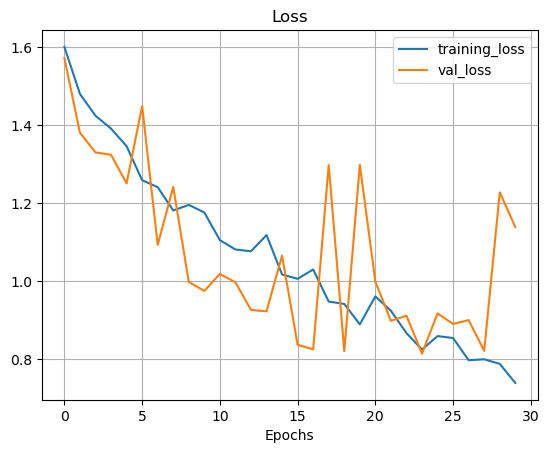

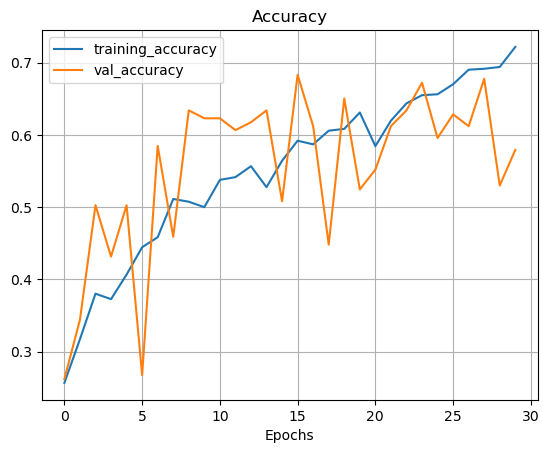

In [27]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))
    #Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    plt.figure()
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
plot_loss_curves(history)
    

3/3 [==============================] - 8s 186ms/step


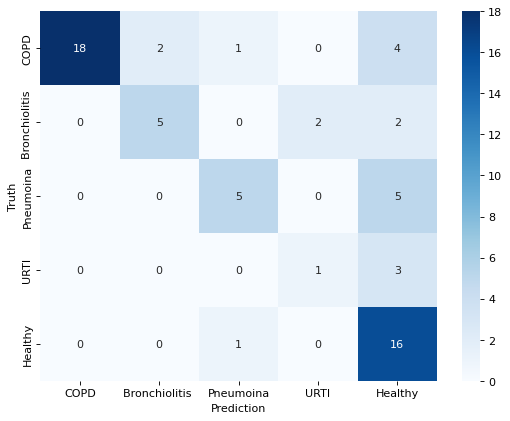

In [28]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in lables_test]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [29]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       1.00      0.72      0.84        25
Bronchiolitis        0.71      0.56      0.63         9
     Pneumoina       0.71      0.50      0.59        10
          URTI       0.33      0.25      0.29         4
       Healthy       0.53      0.94      0.68        17

      accuracy                           0.69        65
     macro avg       0.66      0.59      0.60        65
  weighted avg       0.75      0.69      0.69        65

